# Drill: fixing assumptions

Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality.  Use the cell(s) below to see what you can do to fix it.

In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [ 2.93888937]

R-squared:
0.897210638179


### Multivariate normality

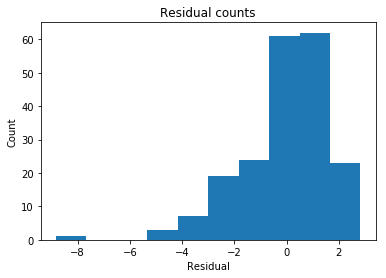

In [3]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

Clearly there's a problem here – substantial negative skew in the histogram of residual counts.

The lesson asserts that skewness in error is often traceable to skewness in data – I'm going to look into the variable distributions individually to see if I can find an obvious culprit.

In [4]:
# Define the histogram plotting function
def plot_hists(frame, vs):
    fig, axes = plt.subplots(1, len(vs), figsize=(12,3))
    for var in vs:
        idx = variables.index(var)
        frame.hist(var, ax=axes[idx])

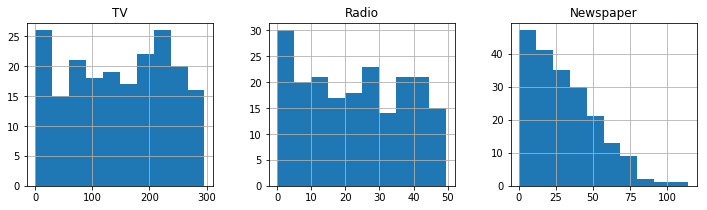

In [5]:
# Plot histograms for each variable
variables = ['TV','Radio','Newspaper']
plot_hists(data, variables)

There's clearly positive skew in newspaper advertising. I'm going to apply a square root transformation to try and fix it.

In [6]:
# Create new features by applying the transformation
data['newspaper_rt'] = data['Newspaper'].apply(lambda x: np.sqrt(x))
data['radio_rt'] = data['Radio'].apply(lambda x: np.sqrt(x))
data['tv_rt'] = data['TV'].apply(lambda x: np.sqrt(x))

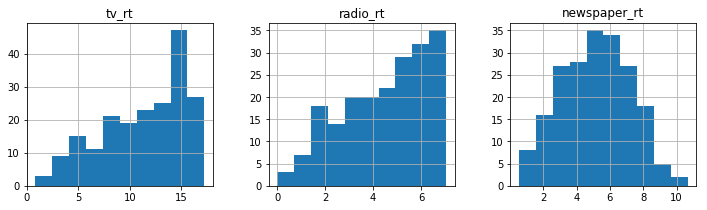

In [7]:
# Plot histograms for the transformed variables
variables = ['tv_rt','radio_rt','newspaper_rt']
plot_hists(data, variables)

When I only applied the square root transformation to newspaper data, it fixed the distribution for that variable, but I got the same (negatively skewed) residual distribution as I did with the untransformed data. However, when I applied the transformation to each variable, it _created skew_ in radio and tv data, but I got a fairly normal residual distribution. ___Why is this?___

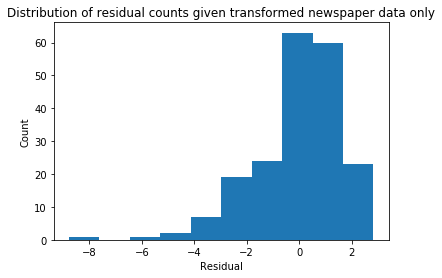

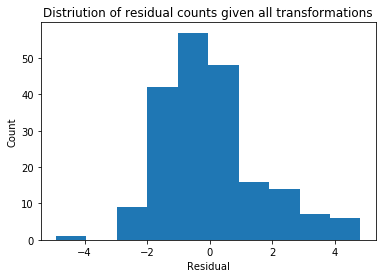

In [8]:
# with only newspaper data transformed
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['Radio','TV','newspaper_rt']]
regr.fit(X, Y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Distribution of residual counts given transformed newspaper data only')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


# with all data transformed
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['radio_rt','tv_rt','newspaper_rt']]
regr.fit(X, Y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Distriution of residual counts given all transformations')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

That said, this looks more regular to me – what do you think?

### Homoscedasticity

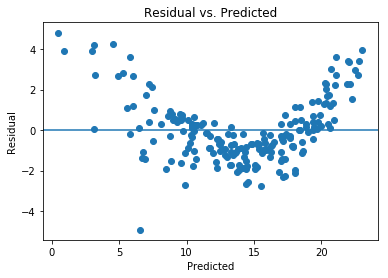

In [9]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

I'm going to try to fix this by creating new, binary features based on radio and TV. 

In [10]:
# Create a function that will transform continuous to categorical variables.
def cont_to_cat(x):
    if x > 0:
        return 1
    else:
        return 0

data['radio_bn'] = data['Radio'].apply(cont_to_cat)
data['tv_bn'] = data['TV'].apply(cont_to_cat)
data['newspaper_bn'] = data['Newspaper'].apply(cont_to_cat)

In [11]:
from scipy import stats
import matplotlib.pyplot as plt

data['radio_bc'] = data['Radio'] + 1
data['radio_bc'] = stats.boxcox(data['radio_bc'])[0]

data['tv_bc'] = data['TV'] + 1
data['tv_bc'] = stats.boxcox(data['tv_bc'])[0]

data['newspaper_bc'] = data['Newspaper'] + 1
data['newspaper_bc'] = stats.boxcox(data['newspaper_bc'])[0]


data['sales_bc'] = stats.boxcox(data['Sales'])[0]

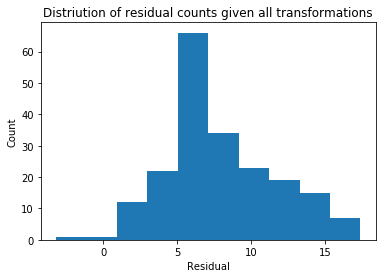

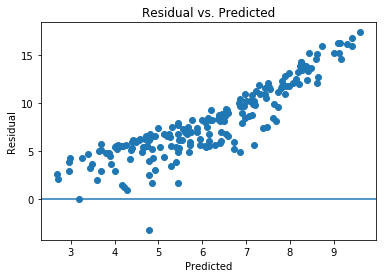

0.882785717206


In [12]:
# with all data transformed
regr = linear_model.LinearRegression()
Y = data['sales_bc'].values.reshape(-1, 1)
X = data[['Radio','TV','Newspaper']]
regr.fit(X, Y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Distriution of residual counts given all transformations')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Test homosedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

print(regr.score(X, Y))

## I've tried re-rolling the model with various permutations of binary, rooted, and un-transformed independent variables. I also tried box-coxing both the independent and dependent variables. This is the best I've gotten. What do you think and what do you advise?